In [ ]:
pip install transformers


In [ ]:
import pandas as pd
import re
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import torch
import copy
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertModel,get_linear_schedule_with_warmup
from torch.optim import AdamW
import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
file_path = "/content/gdrive/My Drive/BT 5153 Final Project"
kaggle_ds = pd.read_csv(file_path + "/twitter_MBTI.csv")
tianchi_ds = pd.read_csv(file_path + "/mbti_1.csv")

In [ ]:
kaggle_ds.head()

,Unnamed: 0,text,label
0,0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,1,@Hispanthicckk Being you makes you look cute||...,intj
2,2,@Alshymi Les balles sont réelles et sont tirée...,intj
3,3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj


In [ ]:
tianchi_ds.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
kaggle_ds.drop(columns=["Unnamed: 0"], inplace=True)
kaggle_ds.columns = ["post", "type"]

tianchi_ds.columns = ["type", "post"]

In [ ]:
kaggle_ds.head()

,post,type
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,@Hispanthicckk Being you makes you look cute||...,intj
2,@Alshymi Les balles sont réelles et sont tirée...,intj
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj


In [ ]:
tianchi_ds.head()

,type,post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
kaggle_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7811 entries, 0 to 7810
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   post    7811 non-null   object
 1   type    7811 non-null   object
dtypes: object(2)
memory usage: 122.2+ KB


In [ ]:
tianchi_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   post    8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [ ]:
kaggle_ds.isnull().sum()

,0
post,0
type,0


In [ ]:
tianchi_ds.isnull().sum()

,0
type,0
post,0


In [ ]:
def explode_column(df, col_to_explode, sep = r"\|\|\|"):
    """
    Split the specified column of a DataFrame into multiple rows by a separator,
    preserving all other columns unchanged.

    param
    ----
    df : imported dataframes
    col_to_explode : str columns want to split
    sep : str regularize expression for "|||"
    """
    df_copy = df.copy()
    # 1) split the text with "|||"
    df_copy[col_to_explode] = df_copy[col_to_explode].str.split(sep)
    # 2) explode
    df_exploded = df_copy.explode(col_to_explode)
    # 3) reset index
    return df_exploded.reset_index(drop=True)

In [ ]:
df1 = explode_column(kaggle_ds, "post")
df2 = explode_column(tianchi_ds, "post")

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093199 entries, 0 to 1093198
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   post    1093199 non-null  object
 1   type    1093199 non-null  object
dtypes: object(2)
memory usage: 16.7+ MB


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422845 entries, 0 to 422844
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   type    422845 non-null  object
 1   post    422845 non-null  object
dtypes: object(2)
memory usage: 6.5+ MB


In [ ]:
df = pd.concat([df1, df2], ignore_index=True)

In [ ]:
df["type"].unique()


array(['intj', 'intp', 'entj', 'entp', 'infj', 'infp', 'enfj', 'enfp',
       'istj', 'isfj', 'estj', 'esfj', 'istp', 'isfp', 'estp', 'esfp',
       'INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

In [ ]:
def clean_text(text):
  """
  clean to text, to lower case, remove abnormal characters or strings like http, @, *, #, etc
  input: str
  output: str
  """
  text = text.lower() #to lower case
  text = re.sub(r"https?://\S+", "", text) #remove links
  text = re.sub(r"@\w+", "", text) #remove @nickname
  text = re.sub(r"#\w+", "", text) #remove 话题
  text = re.sub(r"&amp;|&lt;|&gt;", "", text) #remove all HTML specific entities, avoid left in post
  text = re.sub(r"[^0-9a-zA-Z\s.,!?;:'\"()\[\]{}]", "", text) #keep only numbers, letters, and  punctuaion
  text = re.sub(r"\s+", " ", text).strip() #only keep one space if there are multiple
  return text

In [ ]:
df["post"] = df["post"].apply(clean_text)
df['type']=df['type'].apply(clean_text)

In [ ]:
df

,post,type
0,"the pope is infallible, this is a catholic dog...",intj
1,and by perpetually it entails that the church ...,intj
2,you open the door to unironic nonsense when yo...,intj
3,you dont know your own faith lol you just trie...,intj
4,thats like me saying that im gonna give you a ...,intj
...,...,...
1516039,i was going to close my facebook a few months ...,infp
1516040,30 seconds to mars all of my collections. it s...,infp
1516041,"i have seen it, and i agree. i did actually th...",infp
1516042,ok so i have just watched underworld 4 (awaken...,infp


In [ ]:
df['post_len']=df['post'].str.len()

count    1.516044e+06
mean     7.188012e+01
std      6.448817e+01
min      0.000000e+00
5%       0.000000e+00
25%      1.900000e+01
50%      5.000000e+01
75%      1.100000e+02
95%      1.990000e+02
99%      2.010000e+02
max      2.440000e+02
Name: post_len, dtype: float64


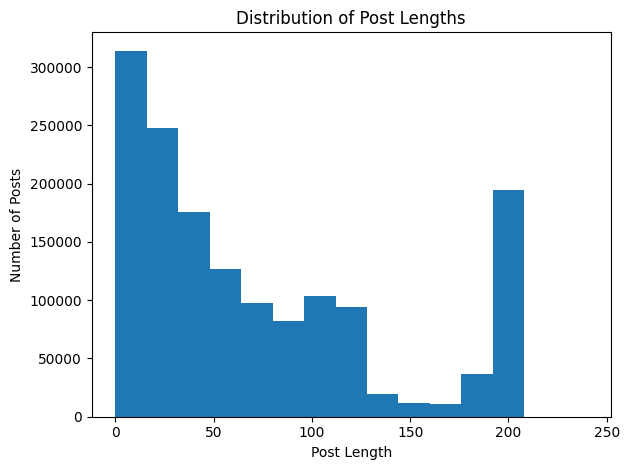

In [ ]:
len_series = pd.Series(df['post_len'], name='post_len')

print(len_series.describe(percentiles=[.05, .25, .5, .75, .95, .99]))


plt.figure()
plt.hist(df['post_len'], bins=range(0,255,16))
plt.title("Distribution of Post Lengths")
plt.xlabel("Post Length")
plt.ylabel("Number of Posts")
plt.tight_layout()

In [ ]:
df = df[df['post_len']>20]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1115844 entries, 0 to 1516043
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   post      1115844 non-null  object
 1   type      1115844 non-null  object
 2   post_len  1115844 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 34.1+ MB


### Encode

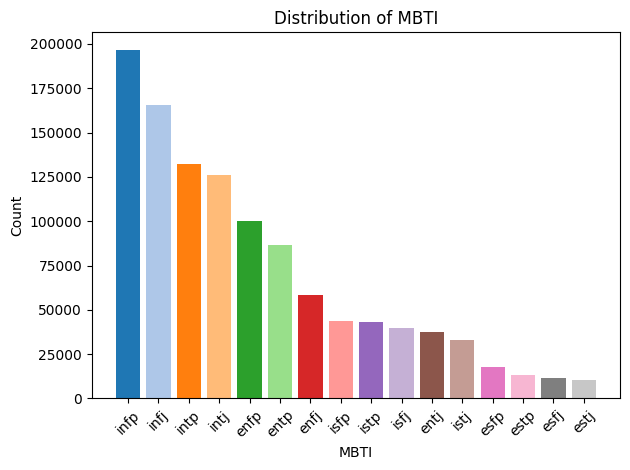

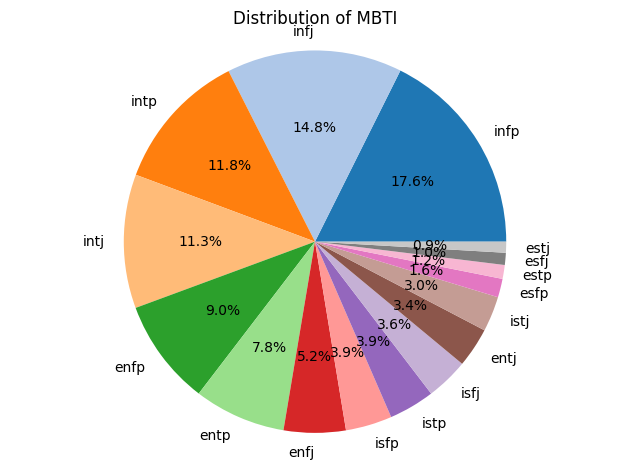

In [ ]:
counts = df['type'].value_counts()
# The variable 'sizes' was not defined.
# Assuming it should represent the counts of each MBTI type, we can replace it with 'counts.values'
colors = plt.get_cmap('tab20')(range(len(counts.values)))

#plot bar plot
plt.figure()
plt.bar(counts.index.astype(str), counts.values, color=colors)
plt.title('Distribution of MBTI')
plt.xlabel('MBTI')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot pie chart
plt.figure()
plt.pie(counts.values, labels=counts.index.astype(str),colors=colors, autopct='%1.1f%%')
plt.title('Distribution of MBTI')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
le = LabelEncoder()
df["label_16"] = le.fit_transform(df["type"])  # 0–15

<ipython-input-88-5e8cb9b4b31e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label_16"] = le.fit_transform(df["type"])  # 0–15


In [ ]:
#四维encoding
df['E'] = df["type"].str[0].map({"e":1, "i":0})
df['N'] = df["type"].str[1].map({"n":1, "s":0})
df['T'] = df["type"].str[2].map({"t":1, "f":0})
df['P'] = df["type"].str[3].map({"p":1, "j":0})


<ipython-input-89-d60e44c529aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['E'] = df["type"].str[0].map({"e":1, "i":0})
<ipython-input-89-d60e44c529aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['N'] = df["type"].str[1].map({"n":1, "s":0})
<ipython-input-89-d60e44c529aa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [ ]:
# 统计每种特质的数量
total = len(df)
indi_char_count = {
    'E': int(df['E'].sum()),
    'I': total - int(df['E'].sum()),
    'N': int(df['N'].sum()),
    'S': total - int(df['N'].sum()),
    'T': int(df['T'].sum()),
    'F': total - int(df['T'].sum()),
    'P': int(df['P'].sum()),
    'J': total - int(df['P'].sum())
}

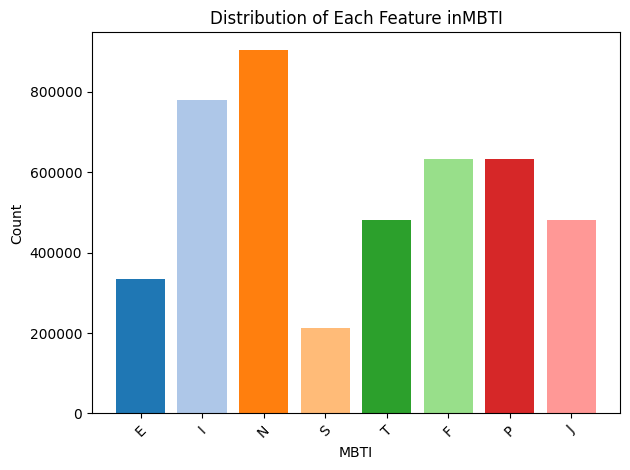

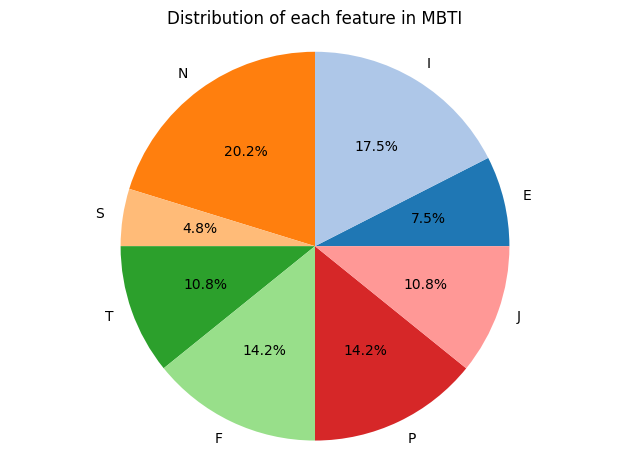

In [ ]:
colors = plt.get_cmap('tab20')(range(len(list(indi_char_count.values()))))

#plot bar plot
plt.figure()
# Access keys and values directly from the dictionary
plt.bar(list(indi_char_count.keys()), list(indi_char_count.values()), color=colors)
plt.title('Distribution of Each Feature inMBTI')
plt.xlabel('MBTI')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot pie chart
plt.figure()
plt.pie(list(indi_char_count.values()), labels=list(indi_char_count.keys()), colors=colors, autopct='%1.1f%%') # Use keys for labels
plt.title('Distribution of each feature in MBTI')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# Undersample to balance 16‑class
X = df[["post"]].values
y = df["label_16"].values
rus = RandomUnderSampler(sampling_strategy="not minority", random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# rebuild DataFrame after resampling
df_resampled = pd.DataFrame({
    "posts": X_res.ravel(),
    "label_16": y_res
})

In [ ]:
# rebuild DataFrame after resampling
df_resampled = pd.DataFrame({
    "posts": X_res.ravel(),
    "label_16": y_res
})

In [ ]:
# regenerate the four binary dims
df_resampled['type'] = le.inverse_transform(df_resampled["label_16"])
df_resampled['E'] = df_resampled["type"].str[0].map({"e":1, "i":0})
df_resampled['N'] = df_resampled["type"].str[1].map({"n":1, "s":0})
df_resampled['T'] = df_resampled["type"].str[2].map({"t":1, "f":0})
df_resampled['P'] = df_resampled["type"].str[3].map({"p":1, "j":0})

In [ ]:
df_resampled

,posts,label_16,type,E,N,T,P
0,hes a pretty swell guy,0,enfj,1,1,0,0
1,ugh. found a flaw in my weights. all better!,0,enfj,1,1,0,0
2,all my life i thought destination is the essen...,0,enfj,1,1,0,0
3,i 100 agree!! it's so much more important to e...,0,enfj,1,1,0,0
4,we need part 2 for real,0,enfj,1,1,0,0
...,...,...,...,...,...,...,...
165563,i dont think i even have that feature so idk i...,15,istp,0,0,1,1
165564,guys rin had enough spare my fellow,15,istp,0,0,1,1
165565,well i didn't try to give a solution to it. i ...,15,istp,0,0,1,1
165566,why the hell is it that every time my friend b...,15,istp,0,0,1,1


In [ ]:
df_resampled['E'].value_counts()

,count
E,
1,82784
0,82784


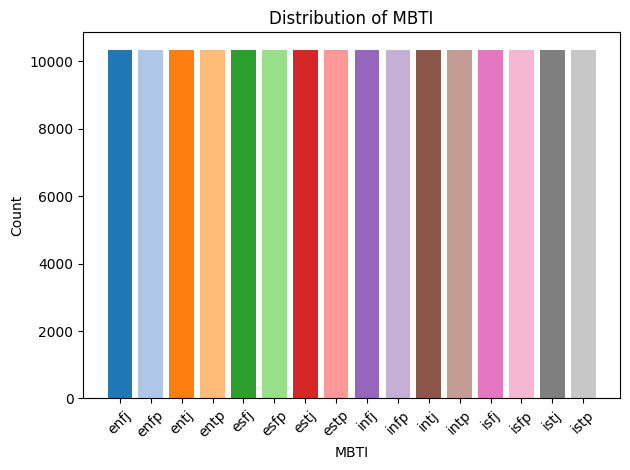

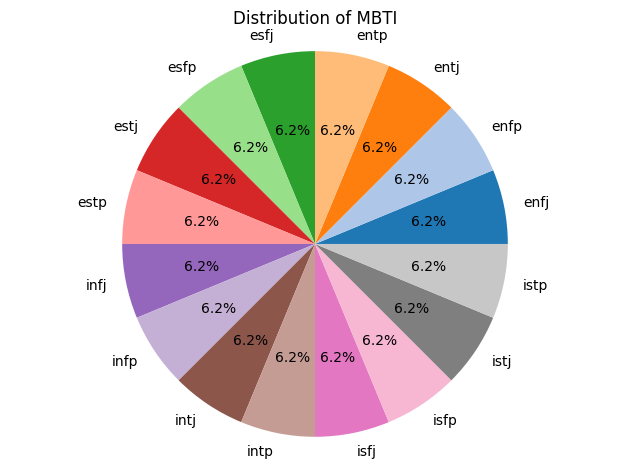

In [ ]:
counts = df_resampled['type'].value_counts()
# The variable 'sizes' was not defined.
# Assuming it should represent the counts of each MBTI type, we can replace it with 'counts.values'
colors = plt.get_cmap('tab20')(range(len(counts.values)))

#plot bar plot
plt.figure()
plt.bar(counts.index.astype(str), counts.values, color=colors)
plt.title('Distribution of MBTI')
plt.xlabel('MBTI')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot pie chart
plt.figure()
plt.pie(counts.values, labels=counts.index.astype(str),colors=colors, autopct='%1.1f%%')
plt.title('Distribution of MBTI')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# 统计每种特质的数量
total = len(df_resampled)
indi_char_count2 = {
    'E': int(df_resampled['E'].sum()),
    'I': total - int(df_resampled['E'].sum()),
    'N': int(df_resampled['N'].sum()),
    'S': total - int(df_resampled['N'].sum()),
    'T': int(df_resampled['T'].sum()),
    'F': total - int(df_resampled['T'].sum()),
    'P': int(df_resampled['P'].sum()),
    'J': total - int(df_resampled['P'].sum())
}

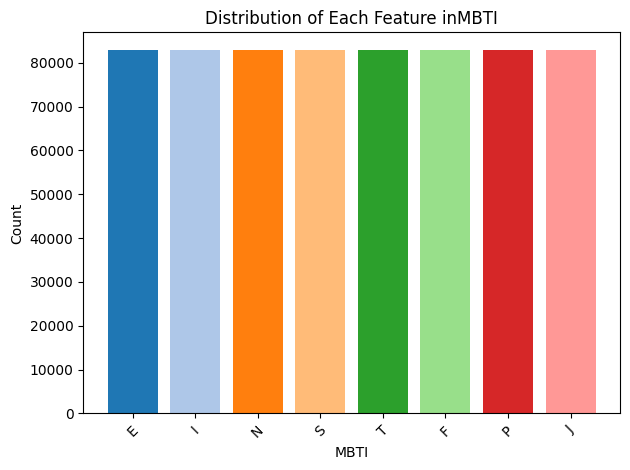

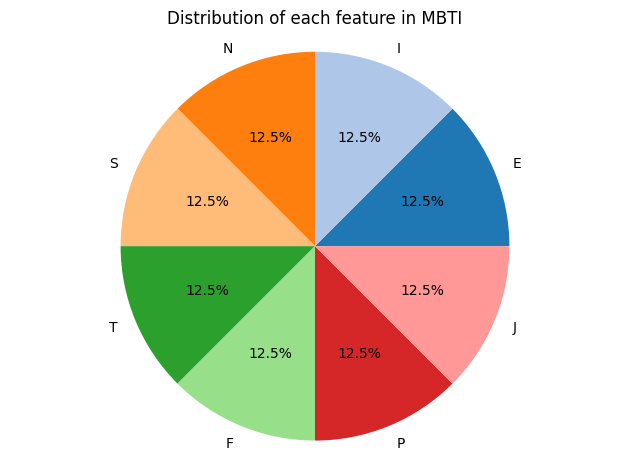

In [ ]:
colors = plt.get_cmap('tab20')(range(len(list(indi_char_count2.values()))))

#plot bar plot
plt.figure()
# Access keys and values directly from the dictionary
plt.bar(list(indi_char_count2.keys()), list(indi_char_count2.values()), color=colors)
plt.title('Distribution of Each Feature inMBTI')
plt.xlabel('MBTI')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot pie chart
plt.figure()
plt.pie(list(indi_char_count2.values()), labels=list(indi_char_count2.keys()), colors=colors, autopct='%1.1f%%') # Use keys for labels
plt.title('Distribution of each feature in MBTI')
plt.axis('equal')
plt.tight_layout()
plt.show()

***Check the max len after tokenization***

In [ ]:
# tokenizer= BertTokenizerFast.from_pretrained('bert-base-uncased')
# texts = df_resampled['posts'].tolist()
# lengths = [
#     len(tokenizer.encode(text, add_special_tokens=True))
#     for text in texts
# ]

# length_series = pd.Series(lengths, name='token length')

# print(length_series.describe(percentiles=[.05, .25, .5, .75, .95, .99]))
# plt.figure()
# plt.hist(lengths, bins=range(0,255,16))
# plt.title("Distribution of Tokenized Post Lengths")
# plt.xlabel("Token Length")
# plt.ylabel("Number of Posts")
# plt.tight_layout()
# plt.show()

***95%          52.000000***

***Train, test, val split***

In [ ]:
train_df, temp_df = train_test_split(
    df_resampled, test_size=0.30, stratify=df_resampled["label_16"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["label_16"], random_state=42
)

In [ ]:
# Tokenize
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
def tokenize_df(data):
    return tokenizer(
        data["posts"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=64,
        return_tensors="pt"
    )

In [ ]:
train_tok = tokenize_df(train_df)
val_tok   = tokenize_df(val_df)
test_tok  = tokenize_df(test_df)

In [ ]:
# Dataset + DataLoader
class MBTIDataset(Dataset):
    def __init__(self, encodings, df):
        self.encodings = encodings
        # 16-class labels
        self.labels_16 = df["label_16"].values
        # 4-dim binary labels
        self.labels_4  = df[["E","N","T","P"]].values.astype(np.float32)

    def __len__(self):
        return len(self.labels_16)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels_16"] = torch.tensor(self.labels_16[idx], dtype=torch.long)
        item["labels_4"]  = torch.tensor(self.labels_4[idx], dtype=torch.float)
        return item

train_dataset = MBTIDataset(train_tok, train_df)
val_dataset   = MBTIDataset(val_tok,   val_df)
test_dataset  = MBTIDataset(test_tok,  test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32)
test_loader  = DataLoader(test_dataset,  batch_size=32)

# BERT+MLP 16 classification

In [ ]:
class MBTIClassifier(nn.Module):
  def __init__(self,pretrained_model_name="bert-base-uncased", hidden_dim1 = 1024,hidden_dim2=512, hidden_dim3=256, num_classes=16, drop_out_rate=0.05, freeze_bert_layers=0):
    super(MBTIClassifier, self).__init__()
    #load pretrained BERT
    self.bert = BertModel.from_pretrained(pretrained_model_name)
    #freeze N layers parameters, acccelerate convergence
    for name, param in self.bert.named_parameters():
      layer_num = None
      if name.startswith('encoder.layer'):
        layer_num = name.split('.')[2]
      if layer_num is not None and int(layer_num) < freeze_bert_layers:
        param.requires_grad = False
    self.classifier = nn.Sequential(
        nn.Linear(self.bert.config.hidden_size, hidden_dim1),
        nn.ReLU(),
        nn.Dropout(drop_out_rate),
        nn.Linear(hidden_dim1, hidden_dim2),
        nn.ReLU(),
        nn.Dropout(drop_out_rate),
        nn.Linear(hidden_dim2, hidden_dim3),
        nn.ReLU(),
        nn.Dropout(drop_out_rate),
        nn.Linear(hidden_dim3, num_classes)
    )
    # forward propagation
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    cls_vector = outputs.last_hidden_state[:, 0, :]  # shape=(batch_size, hidden_size)
    logits = self.classifier(cls_vector)            # shape=(batch_size, num_classes)
    return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MBTIClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-3)
total_steps = len(train_loader) * 5  # 5 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)
criterion = nn.CrossEntropyLoss()


In [ ]:
def train_epoch(loader):
    model.train()
    losses, preds, labels = [], [], []
    for batch in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        mask      = batch["attention_mask"].to(device)
        y_true    = batch["labels_16"].to(device)

        logits = model(input_ids, mask)
        loss = criterion(logits, y_true)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        preds.extend(logits.argmax(dim=1).cpu().numpy())
        labels.extend(y_true.cpu().numpy())

    return np.mean(losses), accuracy_score(labels, preds), f1_score(labels, preds, average="macro")

def eval_epoch(loader):
    model.eval()
    losses, preds, labels = [], [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            mask      = batch["attention_mask"].to(device)
            y_true    = batch["labels_16"].to(device)

            logits = model(input_ids, mask)
            loss = criterion(logits, y_true)
            losses.append(loss.item())

            preds.extend(logits.argmax(dim=1).cpu().numpy())
            labels.extend(y_true.cpu().numpy())

    # basic indexes
    avg_loss = np.mean(losses)
    acc      = accuracy_score(labels, preds)
    f1       = f1_score(labels, preds, average="macro")
    prec     = precision_score(labels, preds, average="macro")
    rec      = recall_score(labels, preds, average="macro")

    # confusion matrix
    cm = confusion_matrix(labels, preds)

    class_names = le.classes_.tolist()
    report = classification_report(labels, preds, target_names=class_names)

    return {
        "loss":      avg_loss,
        "accuracy":  acc,
        "f1_macro":  f1,
        "prec_macro":prec,
        "rec_macro": rec,
        "confusion_matrix": cm,
        "report":    report
    }

In [ ]:
best_accuracy = 0
best_state_dict = None
num_epochs = 5

for epoch in range(num_epochs):
    tr_loss, tr_acc, tr_f1 = train_epoch(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | Train F1: {tr_f1:.4f}")
    val_eval = eval_epoch(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Val Loss: {val_eval['loss']:.4f} | Val Acc: {val_eval['accuracy']:.4f} | Val F1: {val_eval['f1_macro']:.4f}")
    print(f"..............................................................................................")

    if val_eval['accuracy'] > best_accuracy:
        best_accuracy = val_eval['accuracy']
        best_state_dict = copy.deepcopy(model.state_dict())
        print(f"New best model found at epoch {epoch}, the accuracy is {val_eval['accuracy']}.")

# save model path
save_path = f"{file_path}/best_mbti_classifier.pt"
torch.save(best_state_dict, save_path)
print(f"▶ Training complete. Best model (val accuracy={best_accuracy:.4f}) saved to {save_path}")

100%|██████████| 3622/3622 [04:59<00:00, 12.09it/s]


Epoch 1/5 | Train Loss: 2.4933 | Train Acc: 0.2076 | Train F1: 0.2018
Epoch 1/5 | Val Loss: 2.6988 | Val Acc: 0.1491 | Val F1: 0.1458
..............................................................................................
New best model found at epoch 0, the accuracy is 0.14914435272800483.


100%|██████████| 3622/3622 [04:59<00:00, 12.08it/s]


Epoch 2/5 | Train Loss: 2.3167 | Train Acc: 0.2688 | Train F1: 0.2648
Epoch 2/5 | Val Loss: 2.8166 | Val Acc: 0.1479 | Val F1: 0.1452
..............................................................................................


100%|██████████| 3622/3622 [04:59<00:00, 12.09it/s]


Epoch 3/5 | Train Loss: 2.1683 | Train Acc: 0.3177 | Train F1: 0.3144
Epoch 3/5 | Val Loss: 2.9085 | Val Acc: 0.1474 | Val F1: 0.1460
..............................................................................................


100%|██████████| 3622/3622 [04:59<00:00, 12.09it/s]


Epoch 4/5 | Train Loss: 2.1087 | Train Acc: 0.3390 | Train F1: 0.3357
Epoch 4/5 | Val Loss: 2.9085 | Val Acc: 0.1474 | Val F1: 0.1460
..............................................................................................


100%|██████████| 3622/3622 [04:59<00:00, 12.07it/s]


Epoch 5/5 | Train Loss: 2.1096 | Train Acc: 0.3385 | Train F1: 0.3353
Epoch 5/5 | Val Loss: 2.9085 | Val Acc: 0.1474 | Val F1: 0.1460
..............................................................................................
▶ Training complete. Best model (val accuracy=0.1491) saved to /content/gdrive/My Drive/BT 5153 Final Project/best_mbti_classifier.pt


In [ ]:
text_eval = eval_epoch(test_loader)
print(f"Test ▶ Loss: {text_eval['loss']:.4f}, Accuracy: {text_eval['accuracy']:.4f}, F1: {text_eval['f1_macro']:.4f}, Precision: {text_eval['prec_macro']:.4f}, Recall: {text_eval['rec_macro']:.4f}")
print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
print(text_eval['report'])
print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
print(text_eval['confusion_matrix'])

Test ▶ Loss: 2.6687, Accuracy: 0.1451, F1: 0.1383, Precision: 0.1625, Recall: 0.1451
-------------------------------------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

        enfj       0.10      0.16      0.13      1552
        enfp       0.18      0.06      0.09      1552
        entj       0.14      0.16      0.15      1552
        entp       0.21      0.05      0.08      1552
        esfj       0.31      0.11      0.16      1552
        esfp       0.14      0.29      0.19      1552
        estj       0.21      0.15      0.18      1553
        estp       0.14      0.23      0.17      1553
        infj       0.12      0.23      0.16      1552
        infp       0.14      0.13      0.14      1552
        intj       0.15      0.12      0.13      1552
        intp       0.16      0.17      0.16      1552
        isfj       0.14      0.22      0.17      1553
      